In [1]:
# import libraries
from numpy import mean
from numpy import std
from numpy import hstack
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

# reading csv files
df =  pd.read_csv('adult.data', sep=",", header=None, skipinitialspace=True)
df2 = pd.read_csv('adult.test', sep=",", header=None, skipinitialspace=True)

# Join the data and test files together
df = pd.concat([df, df2])

# Shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)

# Replace all of ? with None
df = df.replace(['?'], [None])
# Drop all rows with None in them
df = df.dropna(axis=0)

# Check no None values remain
df.isnull().sum()

#Adding column headers to our data 
df.columns = ["Age", "Workclass", "Fnlwgt", "Education", "Education-num", "Marital-status", "Occupation", "Relationship", "Race", "Sex", "Capital-gain", "Capital-loss", "Hours-per-week", "Native-country", "Income"]
# Workclass, Fnlwgt, Race and Native-country are not worth using.
# Education = Education num, so drop Education
df = df.drop(columns=['Workclass', 'Race', 'Fnlwgt', 'Native-country', 'Education'])


In [2]:
#Numerically encoding occupation: Occupaiton is grouped into white collar and blue collar 
occupation_mapping_dict = {
    "Tech-support" : 0,
    "Craft-repair" : 1, 
    "Other-service" : 1, #Wasn't sure about blue or white collar for other services 
    "Sales" : 0, 
    "Exec-managerial" : 0, 
    "Prof-specialty" : 0, 
    "Handlers-cleaners" : 1, 
    "Machine-op-inspct" : 1, 
    "Adm-clerical" : 0, 
    "Farming-fishing" : 1, 
    "Transport-moving" : 1, 
    "Priv-house-serv" : 1, 
    "Protective-serv" : 1, 
    "Armed-Forces" : 1
    }

df["Occupation"] = df["Occupation"].map(occupation_mapping_dict)


#Numerically encoding the sex variable 
sex_mapping_dict = {
    "Male" : 0,
    "Female" : 1
    }

df["Sex"] = df["Sex"].map(sex_mapping_dict)


#Encoding income variable
income_mapping_dict = {
    "<=50K" : 0,
    ">50K" : 1, 
    "<=50K." : 0, 
    ">50K." : 1
    }

df["Income"] = df["Income"].map(income_mapping_dict)


# FOR MODELS
# Group ages into discrete bins for models
bins = [10,20,30,40,50,60,70,80,90]
names = ['0', '1', '2', '3', '4', '5', '6', '7']
df['Age'] = pd.cut(df['Age'], bins, labels = names)



df

,Age,Education-num,Marital-status,Occupation,Relationship,Sex,Capital-gain,Capital-loss,Hours-per-week,Income
0,2,13,Divorced,0,Unmarried,1,0,0,40,0
1,1,4,Married-civ-spouse,1,Other-relative,1,0,0,30,0
2,2,2,Never-married,1,Not-in-family,0,3674,0,40,0
3,3,9,Divorced,0,Not-in-family,0,0,0,60,0
4,1,9,Married-civ-spouse,1,Husband,0,0,0,50,0
...,...,...,...,...,...,...,...,...,...,...
48837,2,13,Married-civ-spouse,1,Husband,0,0,0,30,0
48838,2,9,Divorced,1,Not-in-family,0,0,0,40,0
48839,3,10,Married-civ-spouse,0,Wife,1,0,0,24,1
48840,2,9,Never-married,1,Not-in-family,0,0,0,50,0


In [3]:
#Will now employ one-hot encoding for :  Marital Status and Relationship ; no order in their values
df = pd.get_dummies(df, columns = ['Relationship', 'Marital-status'])

In [4]:
df['Capital-gain'].value_counts()
# 229 values have 99,999 which is ALOT. Is this cap value? or error?

0        41432
15024      498
7688       391
7298       351
99999      229
         ...  
7262         1
1731         1
22040        1
1639         1
2387         1
Name: Capital-gain, Length: 121, dtype: int64

In [5]:
# Will now do feature scaling on Capital-gaine and Capital-loss
col_names = ['Capital-gain', 'Capital-loss']
features = df[col_names]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df[col_names] = scaler.fit_transform(features.values)
df


,Age,Education-num,Occupation,Sex,Capital-gain,Capital-loss,Hours-per-week,Income,Relationship_Husband,Relationship_Not-in-family,...,Relationship_Own-child,Relationship_Unmarried,Relationship_Wife,Marital-status_Divorced,Marital-status_Married-AF-spouse,Marital-status_Married-civ-spouse,Marital-status_Married-spouse-absent,Marital-status_Never-married,Marital-status_Separated,Marital-status_Widowed
0,2,13,0,1,-0.146733,-0.21878,40,0,0,0,...,0,1,0,1,0,0,0,0,0,0
1,1,4,1,1,-0.146733,-0.21878,30,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,2,2,1,0,0.342719,-0.21878,40,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,3,9,0,0,-0.146733,-0.21878,60,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,1,9,1,0,-0.146733,-0.21878,50,0,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,2,13,1,0,-0.146733,-0.21878,30,0,1,0,...,0,0,0,0,0,1,0,0,0,0
48838,2,9,1,0,-0.146733,-0.21878,40,0,0,1,...,0,0,0,1,0,0,0,0,0,0
48839,3,10,0,1,-0.146733,-0.21878,24,1,0,0,...,0,0,1,0,0,1,0,0,0,0
48840,2,9,1,0,-0.146733,-0.21878,50,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [6]:
# Converting Age column data from string to numerical.
df[["Age"]] = df[["Age"]].apply(pd.to_numeric)

In [7]:
# Split X and y
X = df.iloc[:, [0,1,2, 3, 4, 5, 6,8,9,10,11,12,13,14,15,16,17,18,19,20]]
y = df.iloc[:, [7]]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.20)

In [8]:
#Import best Random Forest Model
from sklearn.ensemble import RandomForestClassifier
RFmodel=RandomForestClassifier(n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features='auto', max_depth=20, bootstrap=True)

#Import best Logistic Regression Model
from sklearn.linear_model import LogisticRegression
LRmodel=LogisticRegression(C=0.1, max_iter=4000, penalty='l2', solver='liblinear')

#Import best Gaussian Naive Bayes Model
from sklearn.naive_bayes import GaussianNB
NBmodel=GaussianNB(var_smoothing=0.001873817422860383)


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=1000)
Accuracy: 0.858
Confusion matrix: 
[[6497  382]
 [ 905 1261]]
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      6879
           1       0.77      0.58      0.66      2166

    accuracy                           0.86      9045
   macro avg       0.82      0.76      0.79      9045
weighted avg       0.85      0.86      0.85      9045

F1 score: 66.2%
Area Under Curve (AUC): 0.763
 
LogisticRegression(C=0.1, max_iter=4000, solver='liblinear')
Accuracy: 0.848
Confusion matrix: 
[[6404  475]
 [ 902 1264]]
AxesSubplot(0.125,0.125;0.496x0.755)
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6879
           1       0.73      0.58      0.65      2166

    accuracy                           0.85      9045
   macro avg       0.80     

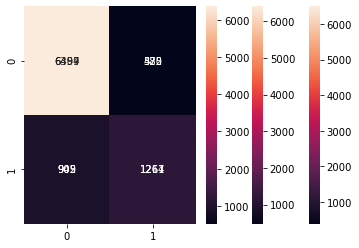

In [9]:
# Import more libraries
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Choices of the three models
choice = [RFmodel, LRmodel, NBmodel]

# Goes through each of the choices and plots their performance metrics
for i in range(3):
    choice[i].fit(X_train, y_train.ravel())
    test_data_predictions = cross_val_predict(choice[i], X_test, y_test.ravel(), cv=20)
    print(choice[i])
    print("Accuracy: " + str(round(accuracy_score(y_test, test_data_predictions),3)))
    
    print("Confusion matrix: ")
    print(confusion_matrix(y_test, test_data_predictions))
    classes_names = ['class 1','class 2','class 3', 'class 4']
    cm = pd.DataFrame(confusion_matrix(y_test, test_data_predictions))
    print(sns.heatmap(cm, annot=True, fmt='d'))
    print(classification_report(y_test, test_data_predictions))
    
    print("F1 score: " + str(round(f1_score(y_test, test_data_predictions)*100,1))+"%")    
    print("Area Under Curve (AUC): " + str(round(roc_auc_score(y_test, test_data_predictions),3)))
    print(" ")



In [46]:
RFmodel 
# 0.8591646626309534
# 0.8601437258153676

LRmodel
# 0.8440722005694226
# 0.8467661691542289

NBmodel
# 0.8298089946651187
# 0.8318407960199005

GaussianNB(var_smoothing=0.001873817422860383)

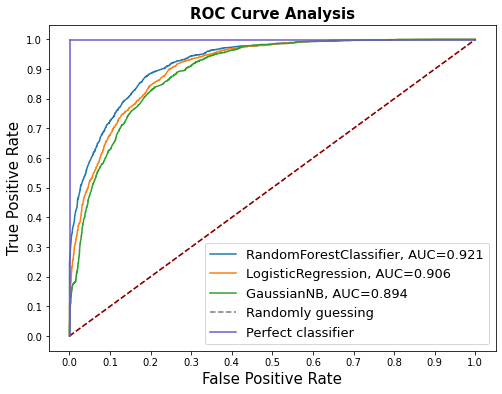

In [10]:
# importing more libraries
from sklearn.metrics import roc_curve, roc_auc_score

# List of all three algorithms
classifiers = [RFmodel, LRmodel, NBmodel]

result_table = pd.DataFrame(columns=['classifiers', 'falsepos','truepos','auc'])

# Form a table of performance metrics for each algorithm
for algorithm in classifiers:
    model = algorithm.fit(X_train, y_train.ravel())
    yprobability = model.predict_proba(X_test)[::,1]
    
    falsepos, truepos, _ = roc_curve(y_test,  yprobability)
    auc = roc_auc_score(y_test, yprobability)
    
#     Put all the results in a table for each algorithm
    result_table = result_table.append({'classifiers':algorithm.__class__.__name__,
                                        'falsepos':falsepos, 
                                        'truepos':truepos, 
                                        'auc':auc}, ignore_index=True)    

# Set name of the classifiers as labels
result_table.set_index('classifiers', inplace=True)

# Plot graph
fig = plt.figure(figsize=(8,6))

# For each algorithm, plot the results on the graph to form the ROC curve
for n in result_table.index:
    plt.plot(result_table.loc[n]['falsepos'], 
             result_table.loc[n]['truepos'], 
             label="{}, AUC={:.3f}".format(n, result_table.loc[n]['auc']))
    
plt.plot([0,1], [0,1], color='red', linestyle='--')

# Plot random guess classifier
plt.plot([0,1], [0,1], "k--", alpha=0.5, label="Randomly guessing") 

# Plot perfect classifier
plt.plot([0.002,0.002], [0,0.998], "slateblue", label="Perfect classifier")
plt.plot([0.001,1], [0.998,0.998], "slateblue")

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()



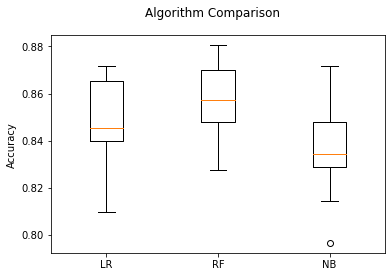

In [14]:
# Compare Algorithms

# prepare models
models = []
models.append((LogisticRegression(C=0.1, max_iter=4000, penalty='l2', solver='liblinear')))
models.append((RandomForestClassifier(n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features='auto', max_depth=20, bootstrap=True)))
models.append((GaussianNB(var_smoothing=0.001873817422860383)))

# evaluate each model
finalresults = []
names = ['LR', 'RF', 'NB']
scoring = 'accuracy'

# Getting mean and std of accuracy for each model
for model in models:
    themodel = model.fit(X_train, y_train.ravel())
    results = cross_val_score(themodel, X_test, y_test.ravel(), cv=20)
    finalresults.append(results)
#     names.append(name)
#     msg = "%s: %f (%f)" % (name, results.mean(), results.std())
#     print(msg)

# boxplot of accuracy against models
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(finalresults)
ax.set_xticklabels(names)
plt.ylabel("Accuracy")

plt.show()

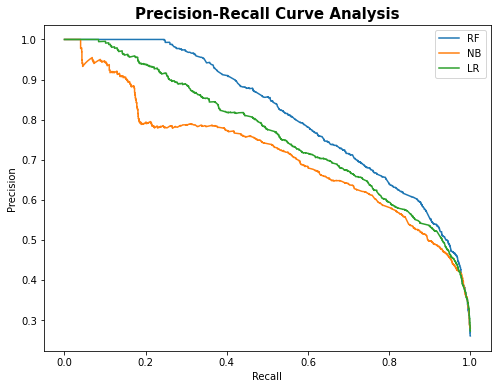

In [17]:
# Import libraries
from sklearn.datasets import make_classification
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot

# prepare models
model1 = RandomForestClassifier(n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features='auto', max_depth=20, bootstrap=True)
model2 = GaussianNB(var_smoothing=0.001873817422860383)
model3 = LogisticRegression(C=0.1, max_iter=4000, penalty='l2', solver='liblinear')

# Fit model against train data
model1.fit(X_train, y_train.ravel())
model2.fit(X_train, y_train.ravel())
model3.fit(X_train, y_train.ravel())

# predict probabilities
probs1 = model1.predict_proba(X_test)
probs2 = model2.predict_proba(X_test)
probs3 = model3.predict_proba(X_test)

# keep probs with positive outcome only
probs1 = probs1[:, 1]
probs2 = probs2[:, 1]
probs3 = probs3[:, 1]

# Find precision and recall values for each model
precision1, recall1, _ = precision_recall_curve(y_test, probs1)
precision2, recall2, _ = precision_recall_curve(y_test, probs2)
precision3, recall3, _ = precision_recall_curve(y_test, probs3)

# Plot curve for each model 
fig = plt.figure(figsize=(8,6))
pyplot.plot(recall1, precision1, label='RF')
pyplot.plot(recall2, precision2, label='NB')
pyplot.plot(recall3, precision3, label='LR')

plt.title('Precision-Recall Curve Analysis', fontweight='bold', fontsize=15)

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')

pyplot.legend()
pyplot.show()